## Time Series Forecasting in Python

### Milestone 1 
#### Preparing the Energy and Temperture Data

In [3]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
# Using the mean_absolute_percentage_error function
from sklearn.metrics import mean_absolute_percentage_error as mape


In [4]:
#importing the data into dataframes
#temperture data
hr_temp = pd.read_csv("hr_temp_20170201-20200131_subset.csv")
#energy data
hrl_metered = pd.read_csv("hrl_load_metered - 20170201-20200131.csv")


In [5]:
#date is done hourly; checking for any nulls in the data
#hr_temp.head()
hr_temp.isnull().sum()

STATION                      0
DATE                         0
REPORT_TYPE                  0
SOURCE                       0
HourlyDryBulbTemperature    37
dtype: int64

In [6]:
hr_temp['DATE'] = pd.to_datetime(hr_temp['DATE'],format='%Y-%m-%d %H:%M:%S')
hr_temp.dtypes

STATION                              int64
DATE                        datetime64[ns]
REPORT_TYPE                         object
SOURCE                               int64
HourlyDryBulbTemperature           float64
dtype: object

In [7]:
hr_temp.head()

,STATION,DATE,REPORT_TYPE,SOURCE,HourlyDryBulbTemperature
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0


In [8]:
#interpolation for missing values
hr_temp['HourlyDryBulbTemperature'].interpolate(inplace=True)

#Extract all the date time information for joins & et
hr_temp['hour'] = pd.DatetimeIndex(hr_temp['DATE']).hour
hr_temp['weekday'] = pd.DatetimeIndex(hr_temp['DATE']).weekday
hr_temp['month'] = pd.DatetimeIndex(hr_temp['DATE']).month
hr_temp['year'] = pd.DatetimeIndex(hr_temp['DATE']).year
hr_temp['date4join'] = pd.to_datetime(hr_temp['DATE']).dt.date

In [9]:
hr_temp.isnull().sum()

STATION                     0
DATE                        0
REPORT_TYPE                 0
SOURCE                      0
HourlyDryBulbTemperature    0
hour                        0
weekday                     0
month                       0
year                        0
date4join                   0
dtype: int64

In [10]:
#date is done hourly; checking for any nulls in the data

hrl_metered.head()

hrl_metered.isnull().sum()

datetime_beginning_utc    0
datetime_beginning_ept    0
nerc_region               0
mkt_region                0
zone                      0
load_area                 0
mw                        0
is_verified               0
dtype: int64

In [11]:
#use datetime_beginning_ept for date
hrl_metered['DATE'] = pd.to_datetime(hrl_metered['datetime_beginning_ept'],format='%m/%d/%Y %H:%M')
hrl_metered['date4join'] = pd.to_datetime(hrl_metered['DATE']).dt.date
hrl_metered['hour'] = pd.DatetimeIndex(hrl_metered['DATE']).hour
hrl_metered.head()

,datetime_beginning_utc,datetime_beginning_ept,nerc_region,mkt_region,zone,load_area,mw,is_verified,DATE,date4join,hour
0,2/1/2017 5:00,2/1/2017 0:00,RFC,WEST,DUQ,DUQ,1419.881,True,2017-02-01 00:00:00,2017-02-01,0
1,2/1/2017 6:00,2/1/2017 1:00,RFC,WEST,DUQ,DUQ,1379.505,True,2017-02-01 01:00:00,2017-02-01,1
2,2/1/2017 7:00,2/1/2017 2:00,RFC,WEST,DUQ,DUQ,1366.106,True,2017-02-01 02:00:00,2017-02-01,2
3,2/1/2017 8:00,2/1/2017 3:00,RFC,WEST,DUQ,DUQ,1364.453,True,2017-02-01 03:00:00,2017-02-01,3
4,2/1/2017 9:00,2/1/2017 4:00,RFC,WEST,DUQ,DUQ,1391.265,True,2017-02-01 04:00:00,2017-02-01,4


In [12]:
energy_data = hrl_metered[['date4join','hour','mw']]

In [13]:
#Create dataframe for the combined energy and temperture data 
temp_energy = hr_temp.merge(energy_data,how='left',on=['date4join','hour'])
temp_energy.rename(columns={'DATE':'date','HourlyDryBulbTemperature':'temp'},inplace=True)
temp_energy.head()

,STATION,date,REPORT_TYPE,SOURCE,temp,hour,weekday,month,year,date4join,mw
0,72520514762,2017-02-01 00:53:00,FM-15,7,37.0,0,2,2,2017,2017-02-01,1419.881
1,72520514762,2017-02-01 01:53:00,FM-15,7,37.0,1,2,2,2017,2017-02-01,1379.505
2,72520514762,2017-02-01 02:53:00,FM-15,7,36.0,2,2,2,2017,2017-02-01,1366.106
3,72520514762,2017-02-01 03:53:00,FM-15,7,36.0,3,2,2,2017,2017-02-01,1364.453
4,72520514762,2017-02-01 04:53:00,FM-15,7,36.0,4,2,2,2017,2017-02-01,1391.265


In [14]:
#checking for nulls after merging
temp_energy.isnull().sum()

STATION        0
date           0
REPORT_TYPE    0
SOURCE         0
temp           0
hour           0
weekday        0
month          0
year           0
date4join      0
mw             3
dtype: int64

In [15]:
#correcting missing values
temp_energy['mw'].interpolate(inplace=True)
temp_energy.isnull().sum()

STATION        0
date           0
REPORT_TYPE    0
SOURCE         0
temp           0
hour           0
weekday        0
month          0
year           0
date4join      0
mw             0
dtype: int64

In [16]:
#dropping extra columns and setting the date as the index
temp_energy.drop(columns=['STATION','REPORT_TYPE','SOURCE','date4join'],inplace=True)
temp_energy = temp_energy[['date','mw','temp','hour','weekday','month','year']]
temp_energy.set_index('date',inplace=True)
temp_energy.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [17]:
"""
Subsetting the data into test & train based on the following:
    - Use all of the data up through 12-31-2019 for training
    - January 2020 as your testing datasets.

Note to self:
test = temp_energy.loc[temp_energy['date'] >= '2020-01-01']  - if date is not indexed
Good references for task 4:
https://statisticsglobe.com/set-datetimeindex-pandas-dataframe-python
https://stackoverflow.com/questions/44547401/pandas-selecting-dataframe-rows-between-two-dates-datetime-index
"""

training = temp_energy[(temp_energy.index.get_level_values(0) < '2020-01-01 00:00:00')]

training.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017


In [18]:


test = temp_energy[(temp_energy.index.get_level_values(0) >= '2020-01-01 00:00:00')]
test.head()

,mw,temp,hour,weekday,month,year
date,,,,,,
2020-01-01 00:53:00,1363.428,31.0,0,2,1,2020
2020-01-01 01:53:00,1335.975,29.0,1,2,1,2020
2020-01-01 02:53:00,1296.817,30.0,2,2,1,2020
2020-01-01 03:53:00,1288.403,30.0,3,2,1,2020
2020-01-01 04:53:00,1292.263,31.0,4,2,1,2020


### Milestone 2
#### Exploring/Visualizing Energy and Temperture Data
Objective:
Visualize the energy data you are going to model and explore the relationship between the energy data and corresponding temperature data. We will use the takeaways from these explorations to build our first model in the next section.

<Axes: xlabel='date', ylabel='Energy'>

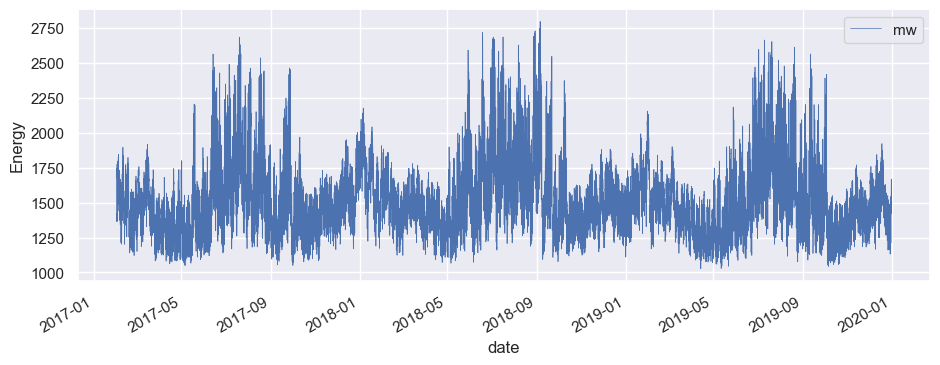

In [20]:
"""
Plotting the training energy data over time
Note to self:
Initally was going to seabourne but it had errors using the index values. Usingmatplotlib instead. See
https://github.com/mwaskom/seaborn/issues/2515
#sns.lineplot(x=training.index, y='mw',data=training)  
#This is a good tutorial as reccomended by the instructor:
https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
Using seaborn styling
The generic overall pattern from the plot below is that peak energy consumption is between June and August (summer months in). 
The lower energy usage is in the spring(April-June) and fall seasons(Sept - Nov)
"""
sns.set(rc={'figure.figsize':(11,4)})
training.plot(y='mw',ylabel= "Energy",linewidth=0.5)

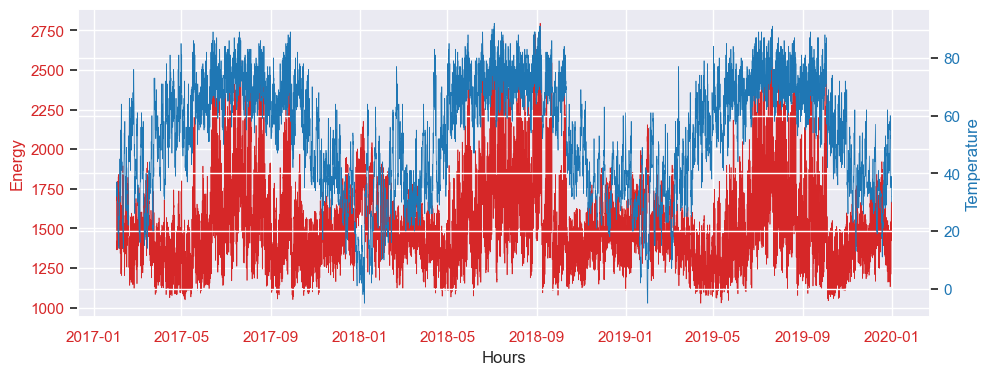

In [21]:
#Overlaying the overall energy and temperture data

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training['mw'],linewidth=0.5,label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training['temp'],linewidth=0.5,label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

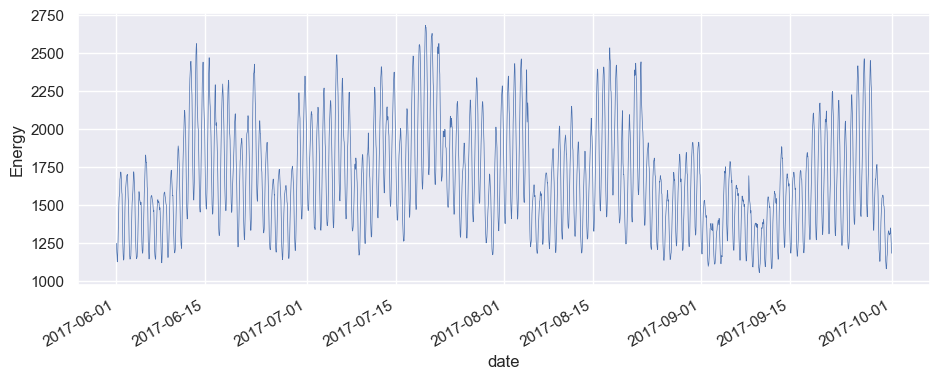

In [22]:
#Looking at months June - September
training['mw'].loc['2017-06':'2017-09'].plot(ylabel= "Energy",linewidth=0.5)

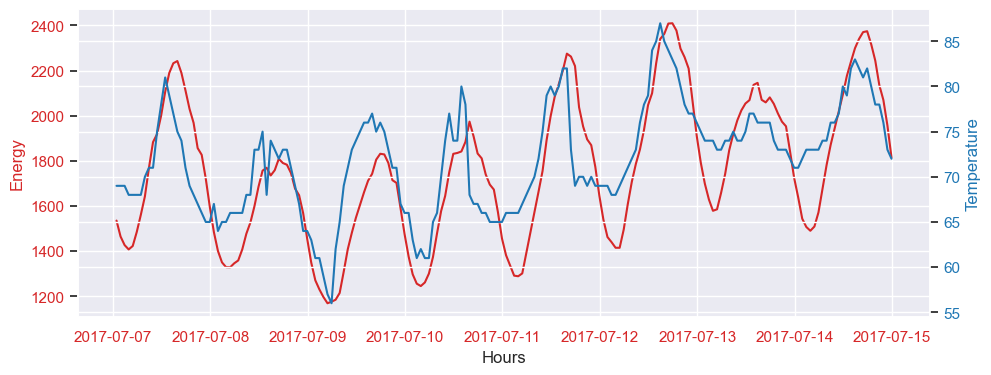

In [23]:
#Plotting one week July 7 - June 14 2017
#Overlaying energy and temperature 
#Energy and Temperture peaks appear to have a xorrelated relationship
sStart,sEnd = '2017-07-07','2017-07-14'
#training['mw'].loc['2017-07-07':'2017-07-14'].plot(linewidth=0.5,ylabel="Energy",marker='o',linestyle='-')

fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[sStart:sEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[sStart:sEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

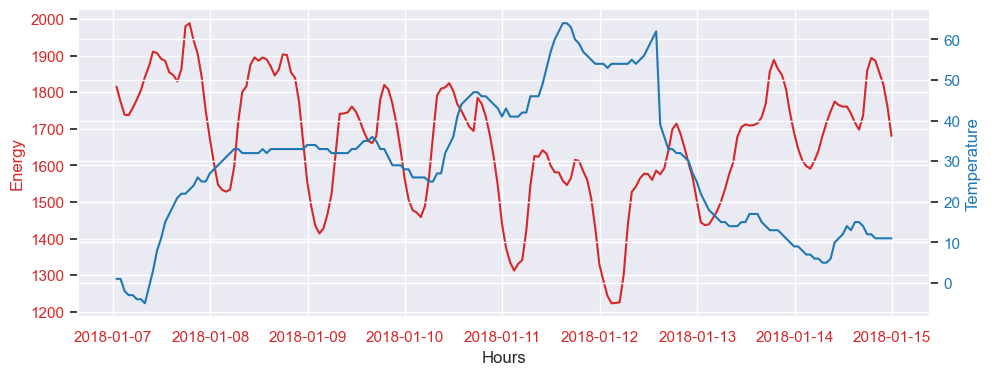

In [24]:
#Plotting one week Jan 7 - Jan 14 2017
#Overlaying energy and temperature 
#For the winter month snapshot, energy and temperture do not appear to have 
#a correlated relationship 
wStart,wEnd = '2018-01-07','2018-01-14'


fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc[wStart:wEnd,'mw'],linestyle='-',label='Energy',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc[wStart:wEnd,'temp'],linestyle='-',label='Temperature',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)

<Axes: xlabel='date', ylabel='Energy'>

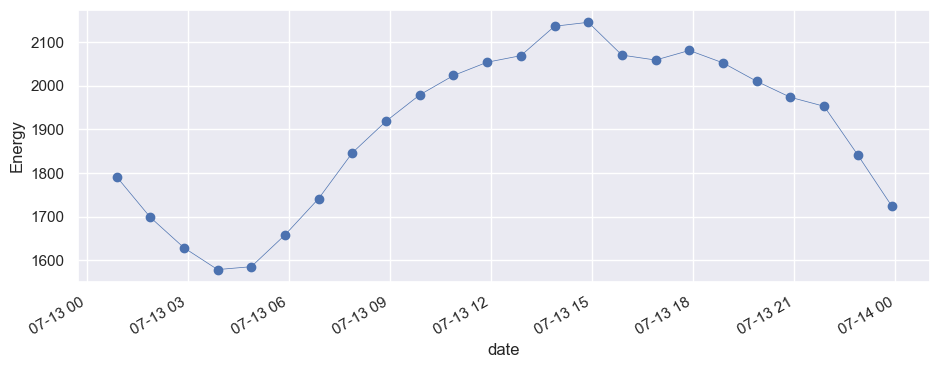

In [25]:
#Consider one day with energy only
training['mw'].loc['2017-07-13'].plot(linewidth=0.5,ylabel= "Energy",marker='o',linestyle='-')

<Axes: xlabel='date', ylabel='Temperture'>

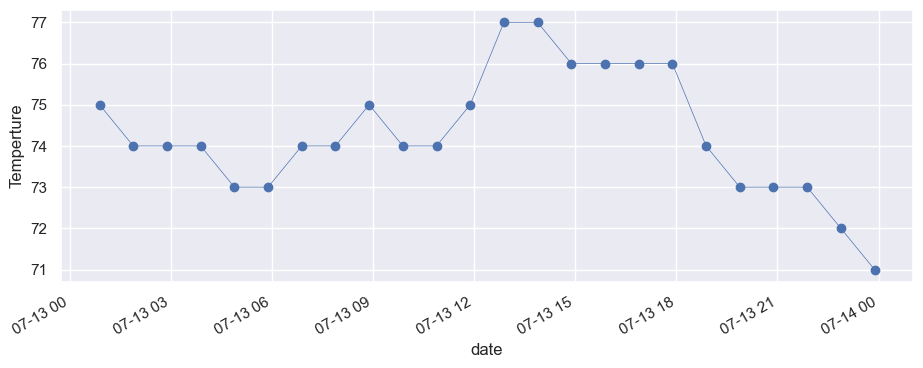

In [26]:
#Adding temp only
training['temp'].loc['2017-07-13'].plot(linewidth=0.5,ylabel="Temperture",marker='o',linestyle='-')

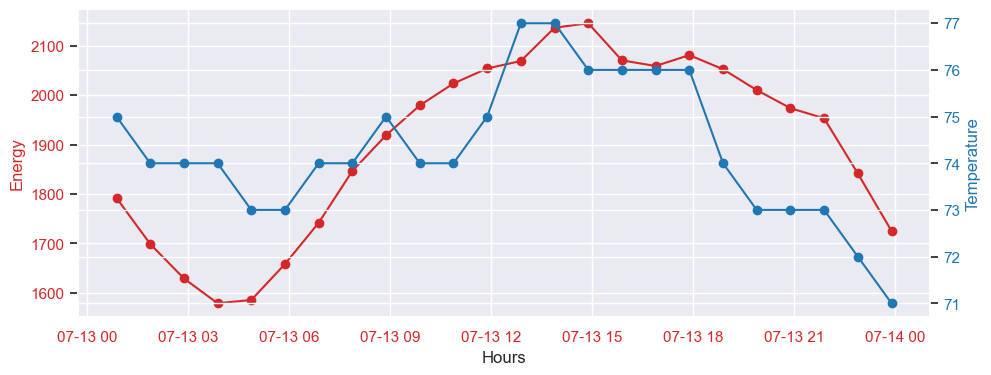

In [27]:
#tempeture and energy overlay using twinx
#One day
fig, ax = plt.subplots()
ax2 = ax.twinx() #instantiate a second Axes that shares the same x-axis

color1 = 'tab:red'
ax.plot(training.loc['2017-07-13','mw'],marker='o',linestyle='-',label='Energy(mw)',color=color1)
ax.set_xlabel('Hours')
ax.set_ylabel('Energy',color=color1)
ax.tick_params(labelcolor=color1)

color2 = 'tab:blue'
ax2.plot(training.loc['2017-07-13','temp'],marker='o',linestyle='-',label='Temperature(F)',color=color2)
ax2.set_ylabel('Temperature',color=color2)
ax2.tick_params(labelcolor=color2)
#ax.legend()


In [28]:
"""
#Calculate the correlation 
#Using Pearson
Note: Pearson (product-moment) correlation coefficient is a measure of the linear relationship between two features.
Pearson value is low (less than .5) which suggests the relationship between energy and temperture is positive and a weak correlation  

"""
pcorrelation = training['mw'].corr(training['temp'])
scorrelation = training['mw'].corr(training['temp'],method='spearman')
kcorrelation = training['mw'].corr(training['temp'],method='kendall')

print("The Pearson correlation between energy and temperture is: ",pcorrelation)
print("The Spearman rho between energy and temperture is: ",scorrelation)
print("The Kendall tau between energy and temperture is: ",kcorrelation)

The Pearson correlation between energy and temperture is:  0.3230645944433782
The Spearman rho between energy and temperture is:  0.30807462199707325
The Kendall tau between energy and temperture is:  0.2059532974957308


Text(0.5, 1.0, 'Energy and Temp Scatter')

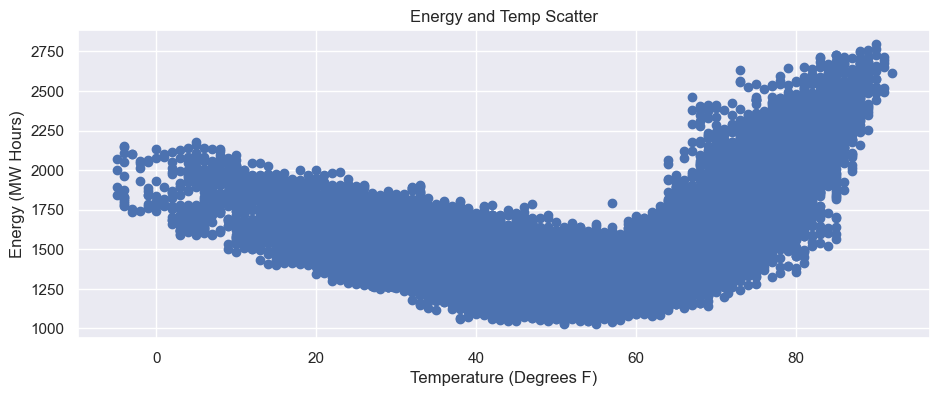

In [29]:
#Scatter Plot
plt.scatter(x='temp',y='mw',data=training)
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
plt.title("Energy and Temp Scatter")

## Milestone 3
### Building the Naive Energy Model
Objective:
Linear regression models are great initial models to build that predict a continuous variable (like energy usage). The typical linear regression modeling framework uses what we call ordinary least squares (OLS) to develop the model. For more information on OLS regression feel free to click on the help section below or look further into the resources!

The foundation is laid in this step. Model building can be complicated, and sometimes it is hard to know when to stop. The best plan is to build a foundational model that you can try to build upon or outperform with later editions of your model. Without a good baseline, you won’t know how good your final model is. These seasonal effects of hours of day, days of week, and months of year, as well as the temperature effects, build a great first attempt at forecasting future energy usage.

In [31]:
"""
It is always good practice to standardize (mean of 0 and standard deviation of 1) any variable 
you are going to raise to a higher power in a regression to help prevent 
multicollinearity problems.

We will do this with the temperture.

Me: From the previous plot the shapre indicates this is not a vanilla regression but is quadratic.
"""

#training['tempSq'] = training['temp'].apply(lambda x: np.square(x))
new_training = training.assign(tempSq = lambda x: np.square(training['temp']))
new_training.head()

,mw,temp,hour,weekday,month,year,tempSq
date,,,,,,,
2017-02-01 00:53:00,1419.881,37.0,0,2,2,2017,1369.0
2017-02-01 01:53:00,1379.505,37.0,1,2,2,2017,1369.0
2017-02-01 02:53:00,1366.106,36.0,2,2,2,2017,1296.0
2017-02-01 03:53:00,1364.453,36.0,3,2,2,2017,1296.0
2017-02-01 04:53:00,1391.265,36.0,4,2,2,2017,1296.0


In [32]:
#playing around with the regression models
"""
Note: Start with a basic regression model using one variable
Not sure what the difference is but I get different results when I use OLS & OLS.from_formula
Will use OLS.from_formula for now. Keeping the other method as a comment

results = sm.OLS(new_training['mw'],new_training['temp']).fit()
print(results.summary())
"""
#Step 2
res = sm.OLS.from_formula('mw ~ temp',data= new_training).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.104
Method:                 Least Squares   F-statistic:                     2976.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:04:38   Log-Likelihood:            -1.7934e+05
No. Observations:               25539   AIC:                         3.587e+05
Df Residuals:                   25537   BIC:                         3.587e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1297.8529      5.100    254.501      0.0

In [33]:
"""
Step 2b.
Based on our knowledge including more variables as factors
# C() denotes treating variable explicitly as categorical
# Higher R squared value using the other variables but notes suggest multicolinearity
"""
resF = sm.OLS.from_formula('mw ~ temp + C(hour) + C(weekday) + C(month) + tempSq',data= new_training).fit()
print(resF.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     2770.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:04:39   Log-Likelihood:            -1.5883e+05
No. Observations:               25539   AIC:                         3.178e+05
Df Residuals:                   25496   BIC:                         3.181e+05
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        2139.3342      6.764    3

In [34]:
#print(resF.params)
print(resF.rsquared)

0.8202457055902288


Text(0.5, 1.0, 'Energy and Temp Scatter for January and July')

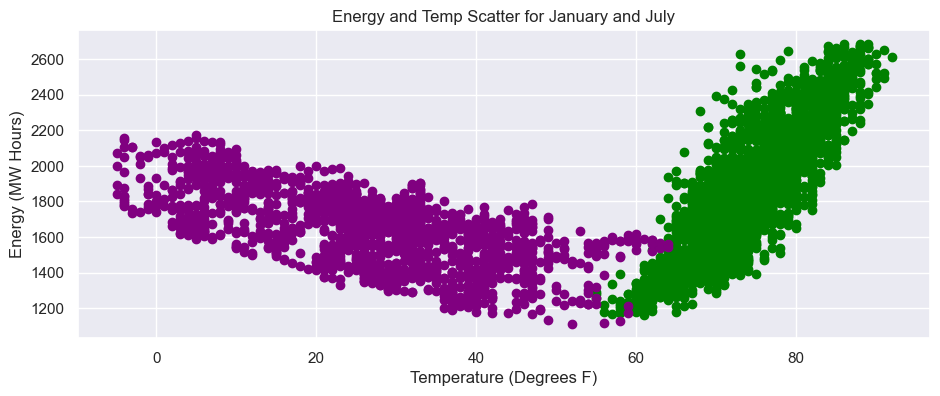

In [35]:
"""
Step 3
Plot the scatterplot between energy and temperature (as in the previous section), 
but only for the months of January and July.

The relationship between energy and temperture is different from summer and winter
Note: Asking deeper questions of the data by looking at examples of winter and summer represented data
"""

plt.scatter(x='temp',y='mw',data= new_training[new_training['month']== 7],color = 'green')
plt.scatter(x='temp',y='mw',data= new_training[new_training['month']== 1],color = 'purple')
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
# Add Legend
plt.title("Energy and Temp Scatter for January and July")

Text(0.5, 1.0, 'Energy and Temp Scatter for Hours Noon and Midnight')

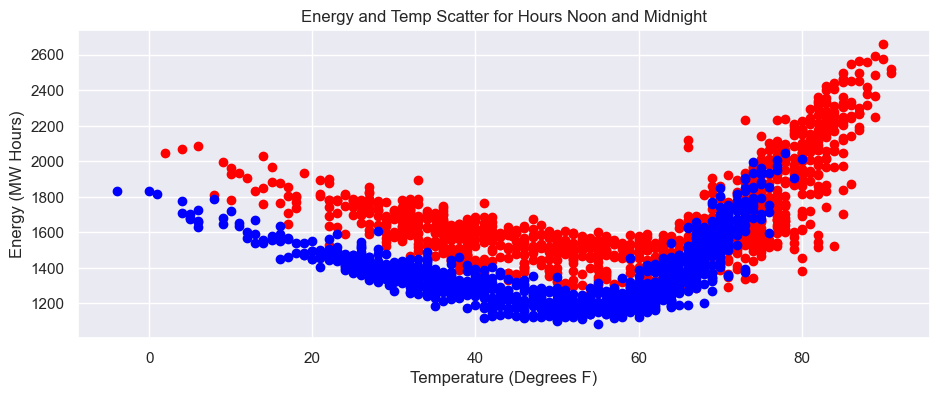

In [36]:
"""
Step 4
Plot the scatterplot between energy and temperature (as in the previous section), 
but only for the hours of midnight and noon.

Note: Even deeper look with hours included. Understanding more about the relationships will help direct the next steps to take.
"""

plt.scatter(x='temp',y='mw',data= new_training[new_training['hour']== 12],color = 'red')
plt.scatter(x='temp',y='mw',data= new_training[new_training['hour']== 0],color = 'blue')
plt.xlabel("Temperature (Degrees F)")
plt.ylabel("Energy (MW Hours)")
# Add Legend
plt.title("Energy and Temp Scatter for Hours Noon and Midnight")

In [37]:
"""
Step 5
The previous two steps reveal that energy has a different relationship with temperature depending on what time 
of day and month of year it is. These are called interactions between variables for a linear regression. Without 
those plots we might have missed that energy has a changing effect with temperature at different times. 
Add these new interactions to the linear regression model you previously built.

Interactions between variables is represented as multiplication between the two variables in a linear reression model

R-squared value is better 0.902 

The con. number is very large
"""
resF_inter = sm.OLS.from_formula('mw ~ C(hour)*temp + C(hour)*tempSq + C(month)*temp + C(month)*tempSq',data= new_training).fit()
print(resF_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                     1570.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:04:40   Log-Likelihood:            -1.5515e+05
No. Observations:               25539   AIC:                         3.105e+05
Df Residuals:                   25434   BIC:                         3.114e+05
Df Model:                         104                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1837.75

In [38]:
"""
Step 6
the relationship between energy and hour of day changes depending on what day of the week it is. 
Add this new interaction to your linear regression model and evaluate your model.
Adding the interaction of the day of the week to the model

New r-squared is 0.904
"""

resF_inter = sm.OLS.from_formula('mw ~ C(hour)*temp + C(hour)*tempSq + C(weekday)*temp + C(weekday)*tempSq  + C(month)*temp + C(month)*tempSq ',data= new_training).fit()
print(resF_inter.summary())

                            OLS Regression Results                            
Dep. Variable:                     mw   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                     1971.
Date:                Thu, 03 Apr 2025   Prob (F-statistic):               0.00
Time:                        11:04:40   Log-Likelihood:            -1.5077e+05
No. Observations:               25539   AIC:                         3.018e+05
Df Residuals:                   25416   BIC:                         3.028e+05
Df Model:                         122                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1794

In [82]:
"""
Step 7
Calculate the predictions (or fitted values) from your final linear regression model on your training dataset. 
Calculate the MAPE(mean absolute percentage error) for these predictions from your training dataset.

Notes: creating a function using numpy. sklearn has a function that I would like to compare 
"""
def calc_mape(y_true,y_pred):
    #description: calculate the mean absolute percentage error
    y_true,y_pred = np.array(y_true),np.array(y_pred)
    calculated_mape = np.mean(np.abs((y_true - y_pred)/y_true))*100
    return np.round(calculated_mape, decimals = 3)


mw_pred = resF_inter.predict()
len(mw_pred)

25539

In [84]:
len(new_training['mw'])
my_mape = calc_mape(new_training['mw'],mw_pred)
print("MAPE for training set: ",my_mape)

MAPE for training set:  4.093


In [41]:
#new_training['mw'].isnull().sum()

0